In [1]:
# Data
import numpy as np
# if __name__ == '__main__':
with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}
    
    X = [char_to_idx[x] for x in txt]
    X = np.array(X)
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

# Data exploration
X.shape, y.shape, X, y, txt.split()[:2], 
# set(txt), 
# for val, key in enumerate(set(txt)):
#     print(val, key)
val2char = {val: key for val, key in enumerate(set(txt))}
# val2char

In [2]:
# Model
import impl.loss as loss_fun
import impl.layer as l
import impl.utils as util
import impl.NN as nn

class RNN(nn.NN):

    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'valid':[], 'test':[]}
        super().__init__(D, D, H, None, None, loss='cross_ent', nonlin='relu')

    def _init_model(self, D, C, H):
        m = dict(
            Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Why=np.random.randn(H, D) / np.sqrt(C / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
            )
        self.model = []
        for l in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wxh, Whh, Why = m['Wxh'], m['Whh'], m['Why']
        bh, by = m['bh'], m['by']

        hprev = h.copy()

        h, h_cache = l.tanh_forward(X @ Wxh + hprev @ Whh + bh)
        y, y_cache = l.fc_forward(h, Why, by)

        cache = X, Whh, h, hprev, y, h_cache, y_cache, Wxh

        return y, h, cache

    def backward(self, dy, dh, cache):
        X, Whh, h, hprev, y, h_cache, y_cache, Wxh = cache

        dh_next = dh.copy()
        
        # Hidden to output gradient
        dh, dWhy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dby = dby.reshape((1, -1))

        # tanh
        dh = l.tanh_backward(dh, h_cache)

        # Hidden gradient
        dbh = dh
        dWhh = hprev.T @ dh
        dWxh = X.T @ dh
        
        dX = dh @ Wxh.T
        dh = dh @ Whh.T

        grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for l in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
                caches[l].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
#             loss += loss_fun.cross_entropy(self.model[0], y_pred, y, lam=0)/ y_train.shape[0]
            loss += loss_fun.cross_entropy(y_pred, y)/ y_train.shape[0]
            dy = loss_fun.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for l in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for l in reversed(range(self.L)):
                dX, dh[l], grad[l] = self.backward(dX, dh[l], caches[l][t])
                for k in grad[0].keys():
                    grads[l][k] += grad[l][k]
                
        return dX, grads
    
    def test(self, X_seed, h, size=100):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for l in range(self.L):
            h.append(h_init.copy())

        for _ in range(size - 1):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for l in range(self.L):
                y, h[l], _ = self.forward(y, h[l], self.model[l])
                
            prob = util.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [3]:
import numpy as np
import impl.utils as util
import impl.constant as c
import copy
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle=True):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha=0.001, mb_size=256, n_iter=2000, print_after=100):
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    idx = 0
    state = nn.initial_state()
    loss = np.log(len(set(X_train)))
#     smooth_loss = -np.log(1.0 / len(set(X_train)))

    
    M, R = [], []
    for l in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        
    beta1 = .9
    beta2 = .999

    for iter in range(1, n_iter + 1):

        if idx >= len(minibatches):
            idx = 0
            state = nn.initial_state()

        X_mini, y_mini = minibatches[idx]
        idx += 1

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
#             print('Iter-{} loss: {:.4f}'.format(iter, smooth_loss))
            sample = nn.test(X_mini[0], state)
            print(sample)

        ys, caches = nn.train_forward(X_mini, state)
        loss, dys = nn.loss_function(y_mini, ys)
        dX, grads = nn.train_backward(dys, caches)
#         smooth_loss = 0.999 * smooth_loss + 0.001 * loss
        nn.losses['train'].append(loss)


        for l in range(nn.L):
            for k in grads[0].keys(): #key, value: items
                M[l][k] = util.exp_running_avg(M[l][k], grads[l][k], beta1)
                R[l][k] = util.exp_running_avg(R[l][k], grads[l][k]**2, beta2)

                m_k_hat = M[l][k] / (1. - beta1**(iter))
                r_k_hat = R[l][k] / (1. - beta2**(iter))

                nn.model[l][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + c.eps)
    
    return nn

In [5]:
vocab_size = len(char_to_idx)

# hyper parameters
time_step = 100 # width
num_layers = 1 # depth
n_iter = 13000 # epochs
alpha = 1e-3 # learning_rate
print_after = 1000 # print loss, valid, and test
H = 64 # num_hidden_units in hidden layer

In [6]:
net = RNN(D=vocab_size, H=H, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

Iter-1000 loss: 2.6860
Jy4Gh lamery areatoktcke tbonry ofputhe warce, aretRs candein ty we)ooasan taud she omgkto upry: Jap
Iter-2000 loss: 1.7064
 horanre  derif tarestar 'ound coperc9rs ond iksthetand hirthe Woridt encintry Hr antend in makuimin
Iter-3000 loss: 1.1937
 Eaperof ufril pan"e, phimargiss himeoumrkean, rind of are mortho se-partil iRsty cendes as Eepera a
Iter-4000 loss: 0.8608
eref largy in he the Wenter ariy iith itogis lat. Thethe hedtre conn eang Senind in uran is a, thisa
Iter-5000 loss: 0.9080
 wortraty innd the feit vf ar und necpers, the Nian in the G8rban, the thed pndes and f Japan -l rri
Iter-6000 loss: 1.1420
 Sea in a. hopen an ofarel Japan wad Sua Jng8, therant or and aprea wojsin the mietSe conllopola. io
Iter-7000 loss: 0.8007
ns wanc and insale forland as fWectunine Searye coly peofeand ches8ot ol of wh  anat. Japan s ardent
Iter-8000 loss: 0.6241
. The pota y gowhis ofCrybiof lap ouran tuvingutan Co latar turiocadint in the G8, and the the diper
Iter-900

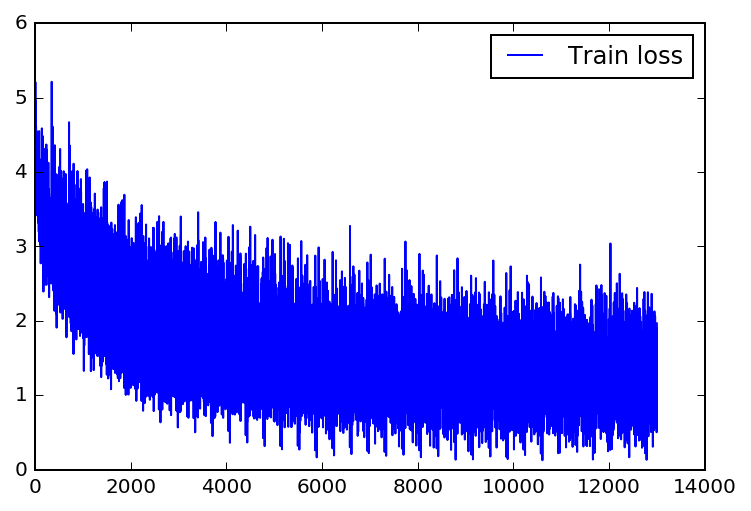

In [11]:
# Display the learning curve and losses for training, validation, and testing
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
# matplot.plot(losses_tx2['valid'], label='Valid loss')
plt.legend()
# _ = plt.ylim()